# Описание



Users of JetBrains products are people from around the world. Each of them has their own specific needs and problems that JetBrains products try to solve. However, there are areas related to different topics and interests that are out of scope of JetBrains products. Knowing the most trending of them can potentially discover evolving markets and help to create new products, identify risks and opportunities for the company.

This internship offers the chance to apply text analysis techniques, mathematical statistics and visualisation to real world data based on discussions of people on the internet. The intern will analyse a large corpus of texts using Python, try different hypotheses and build visualisations on top of that to highlight trend signals.

# Задача 1
Почему Вам интересен этот проект и как Вы видите его реализацию?

Данные это новая валюта, а за машинной обработкой текста будущее, которое уже наступило, и к которому мне очень интересно присоединиться. Мне видится, что решение предлагаемой задачи действительно расширит горизонт развития компании JetBrains, позволит направить усилия в профитном направлении и усовершенствовать существующие или сделать новые клёвые продукты. Для меня это отличный способ применить технологии анализа данных и получить опыт работы над актуальной задачей исследовательской аналитики.

Возможная реализация заключается в анализе сообщений на предмет настроения (положительная/негативная реакция), содержательности (конструктивные предложения/неинформативные сообщения) и извлечения тем сообщений и ключевых слов. Анализируя полученные данные, можно попробовать заметить неудовлетворенные потребности, а также отметить продукты и фичи, которые заслужили особой похвалы.

# Задача 2
В StackOverflow обсуждаются тысячи тем каждый день и используют столько слов и технологий! Вы задались резонным вопросом - какие слова, фразы используются наиболее часто за последние 6 месяцев? Попробуйте ответить на этот вопрос и пришлите решение ссылкой на GitHub, где будут код и графики / таблицы, отвечающие на этот вопрос.


В этом деле вам поможет [StackOverflow Query](https://data.stackexchange.com/stackoverflow/query/new), с помощью которого вы сможете получить необходимую вам выборку данных для анализа.

## Analyzing monograms


The naive solution I came up with at first was the following:
* Download the half-year dataset of posts (questions and answers)
```
SELECT p.Body 
FROM Posts p 
WHERE p.CreationDate >= '20210817 00:00:00.000'
```
* Exlude:
 * stopwords, which do not carry usefull information.
 * sections with code (code-stopwords), which stand out from discussions and spoils the data with unrelevant language patterns or variable names. 
 * other groups of undescriptive words, which are to be revealed during the analysis...
* Obtain mono-, bi-, tri-grams **counting only one occurences per post**.
* Find the most frequent and analyze them on the subject of relevance.
> What is **relevance**? As the problem states we are interested in words related to technologies. What the most discussed software, languages, frameworks, data structures, algorithms, recent problems are.

It appears that [StackOverflow Query](https://data.stackexchange.com/stackoverflow/query/new) limits the size of result set to 50K rows. The amount of 50K of questions and answers is accumulated in ~3 days, which is 50 times smaller timespan than it is requested. 

Anyway, let's see what kind of information can we gather from 3 days of Stackoverflow activity. In the following I employ *BeautifulSoup* to parse xml-like data from requested csv-file and *NLTK* to conviniently workaround stopwords and statistics.



In [24]:
from bs4 import BeautifulSoup as bs
import nltk
nltk.download('stopwords')

import numpy as np
import matplotlib.pyplot as plt

# As noted above, I count one occurnce of word per post,
# which means that I need function to read csv-file row-by-row.
# Another benefit of this implementation is keeping memory low - not 
# reading the GBytes of csv to one variable.
def read_row_lower(file):
    row = ''
    while True:
        line = file.readline()
        if line == '"\n':               # Each row ends with "\n
            return row, 0
        if line == '': # EOF
            return row, 1
        row += line.lower()

stopwords = set()
stopwords |= set(nltk.corpus.stopwords.words('english'))

filepath = '/content/drive/MyDrive/CSC/2022_spring_internship/'
with open(filepath + 'QueryResults1_body_50K.csv', 'r') as file:

    # Consider words at least of 2 symbols
    tokenizer = nltk.tokenize.RegexpTokenizer('[a-z][a-z]+')
    monograms = nltk.FreqDist()
    
    eof = 0
    while eof == 0:
        post, eof = read_row_lower(file)
        soup = bs(post, "lxml")
        try:
            soup.code.decompose()   # Delete code sections, filter code-stopwords
        except: pass
        tokens = tokenizer.tokenize(soup.text)
        
        # count only one occurence per post via applying set()
        monograms += nltk.FreqDist(set(word for word in tokens if word not in stopwords))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


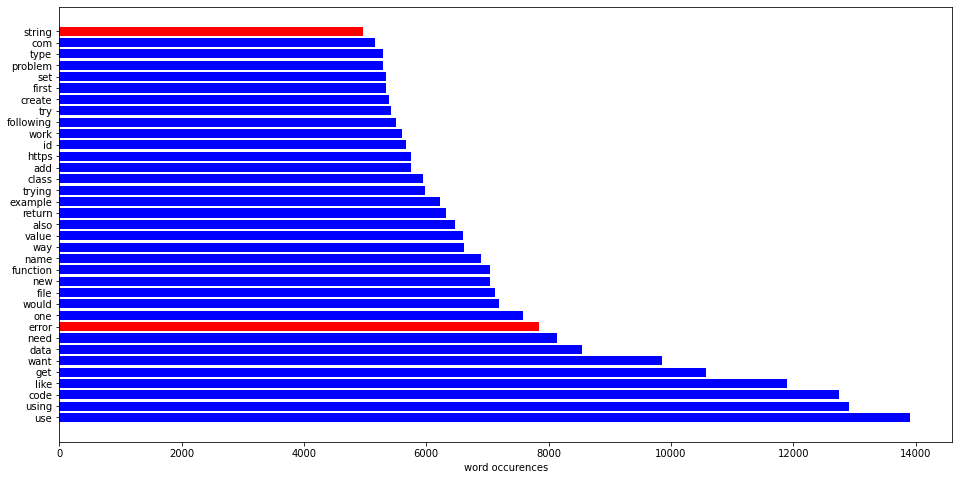

In [78]:
N = 35
monofreq = monograms.most_common(N)
mf_words = [x[0] for x in monofreq]
mf_freq = [x[1] for x in monofreq]
col = ['b']*N
col[8], col[34],  = ['r']*2

plt.figure(figsize=(16,8))
plt.barh(mf_words, mf_freq, color=col)
plt.xlabel('word occurences')
plt.show()

**Disscusion**
* The most frequent monograms do not feature any specificity, they are mostly general. Red highlighted word "error" might refer to the discussion of errors, and "string" to correspondent data type, but these conclusions seem vague.
* Sampling over 3 days gives the general understanding that the kind of words "use", "data" and "get" will be frequent in any sampling, because the size of it already big enough (50K).
* Considering bigrams it is expected to obtain irrelevant "there is", "you need", "using data" kinds to be on the top. Though I haven't elaborated how to filter stopwords in bigrams, I do not expect relevant bigrams to be frequent.
* There might be a corpus with forum-used words excluding IT terms, which can be employed to filter irrelevant words. It requires a thorough research to find a proper one.

In the suggestion that problem statement refers to [StackOverflow Query](https://data.stackexchange.com/stackoverflow/query/new) unlike unlimited [Google’s BigQuery](https://stackoverflow.blog/2016/12/15/you-can-now-play-with-stack-overflow-data-on-googles-bigquery/?_ga=2.127300810.695053228.1645084880-1711258392.1634477533) or [datadumps from archive](https://archive.org/details/stackexchange)), solution requires more specific SQL query than selecting all posts. In the following I discuss how we can limit the query.

## Limiting the query
* We can restrict the search to get only posts with high enough score, which reflects general interest in the post and makes it relevant (This query gives already 2760 posts):

```
SELECT p.Id AS [Post Link], p.Score, p.ViewCount
FROM Posts p

WHERE p.CreationDate >= '20210817 00:00:00.000' 
and p.Score >= 10
ORDER BY p.CreationDate ASC
```

* Or we may query only questions from prominent enough authors, which would indicate what professional community is interested in (This query gives already 7009 posts):

```
SELECT p.Id AS [Post Link], p.Score, p.ViewCount, u.Reputation, p.Tags
FROM Posts p
JOIN Users u ON p.OwnerUserId = u.Id

WHERE p.CreationDate >= '20210817 00:00:00.000' 
and p.PostTypeId = 1
and p.ViewCount >= 100
and u.Reputation >= 5000
ORDER BY p.CreationDate ASC
```




Summing up, to solve the original problem:
* Restrict data query in order to get posts, which are actually discussed in the community.
* Retrieve mono-, bi-, trigrams excluding stopwords from specific corpora in order to be left with Stackoverflow-relevant ngrams.

# Solution using tags

The users have done a big part of this job for us, they put tags on their questions, which are easily retrieved. In order to present the result anyhow, the bar plot of tag occurences is given based on the last query with 7009 rows.

In [2]:
with open(filepath + 'QueryResults2_tags.csv') as file:
    line = file.readline()   
    tag_dict = nltk.FreqDist()
    while line != '':
        line = file.readline()
        tag_dict += nltk.FreqDist(line[2:-3].replace('><',' ').split())

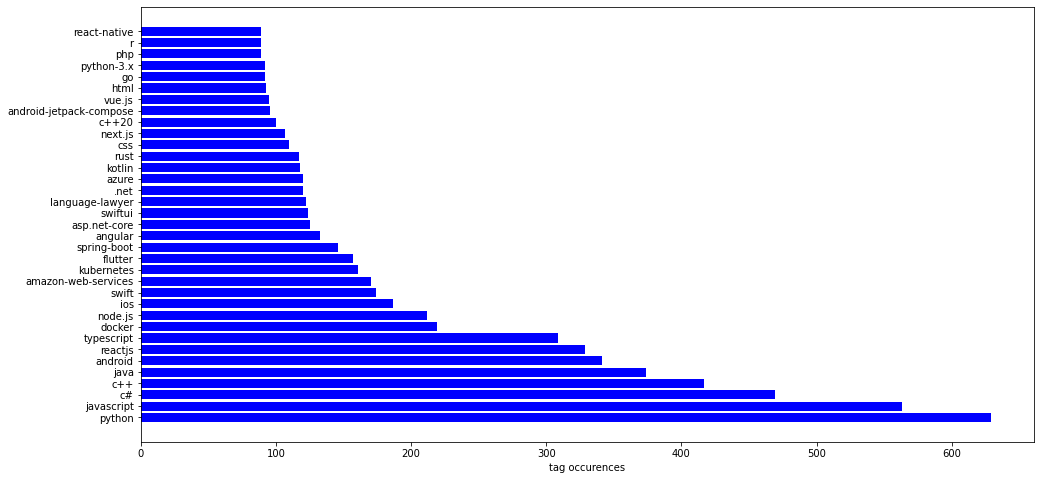

In [3]:
N = 35
tag_freq = tag_dict.most_common(N)
tags = [x[0] for x in tag_freq]
freqs = [x[1] for x in tag_freq]
col = ['b']*N

plt.figure(figsize=(16,8))
plt.barh(tags, freqs, color=col)
plt.xlabel('tag occurences')
plt.show()

This result shows, which technologies were discussed at Stackoverflow the most over the past half-year.